In [1]:
%cd ~/user_data/research/git/zero-shot-object-detection/frontend_owlvit
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit'

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import cv2
from pycocotools.coco import COCO
from transformers import pipeline
from transformers import Owlv2ImageProcessor, Owlv2Processor, Owlv2ForObjectDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import pandas as pd

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/DREXEL/jw3897/miniconda3/envs/owlvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
val_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/instances_val2017.json'

coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=val_annotation_path,
)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [6]:
category_ids = coco_val_dataset.coco.loadCats(coco_val_dataset.coco.getCatIds())
category_names = [category['name'] for category in category_ids]

In [8]:
image_filenames = os.listdir(val_image_dir)
image_filenames.sort()

image_ids = []
for image_filename in image_filenames:
    image_id = image_filename.split('.')[0].lstrip('0')
    image_ids.append(image_id)

In [9]:
print(len(image_ids))

5000


# Comparison Code

In [12]:
sample = coco_val_dataset[0]
image = sample[0]
metadata = sample[1]

In [ ]:
owlvit_checkpoint = r'google/owlv2-base-patch16-ensemble'
owlvit_pipeline = pipeline(model=owlvit_checkpoint, task='zero-shot-object-detection', use_fast=True, device='cuda')
owlvit_model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
owlvit_processor = processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")

owlvit_image_processor = 

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [25]:
inputs = owlvit_processor(text=[category_names], images=image, return_tensors='pt')

In [26]:
with torch.no_grad():
    outputs = owlvit_model(**inputs)

In [66]:
from scipy.special import expit as sigmoid

In [68]:
print(sigmoid(outputs.objectness_logits.squeeze().numpy()))

[5.9143995e-04 5.2966792e-03 5.5779901e-04 ... 4.4699971e-07 7.7311745e-07
 9.0124922e-06]


In [53]:
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values)

In [49]:
print(image.size)

(640, 426)


In [54]:
# Convert outputs (bounding boxes and class logits) to COCO API
target_sizes = [(image.height, image.width)]
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = [category_names][i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected clock with confidence 0.55 at location [448.25, 120.84, 461.7, 142.41]
Detected microwave with confidence 0.23 at location [475.75, 136.43, 526.0, 173.9]
Detected bird with confidence 0.104 at location [458.87, 159.1, 467.28, 168.08]
Detected potted plant with confidence 0.151 at location [491.04, 153.63, 503.55, 173.24]
Detected vase with confidence 0.118 at location [497.08, 161.16, 502.57, 172.98]
Detected potted plant with confidence 0.107 at location [231.88, 139.67, 267.66, 209.89]
Detected potted plant with confidence 0.292 at location [232.12, 177.27, 265.83, 212.5]
Detected potted plant with confidence 0.107 at location [322.27, 181.05, 341.08, 214.14]
Detected potted plant with confidence 0.115 at location [337.9, 176.38, 381.8, 222.03]
Detected person with confidence 0.242 at location [384.31, 172.35, 400.82, 207.95]
Detected oven with confidence 0.221 at location [494.89, 173.64, 512.53, 214.85]
Detected tv with confidence 0.704 at location [5.22, 166.49, 154.24, 2

In [30]:
pipeline_results = owlvit_pipeline(
    image,
    candidate_labels=category_names
)

In [ ]:
pipeline_results

[{'score': 0.7043147087097168,
  'label': 'tv',
  'box': {'xmin': 5, 'ymin': 166, 'xmax': 154, 'ymax': 267}},
 {'score': 0.5502265095710754,
  'label': 'clock',
  'box': {'xmin': 448, 'ymin': 120, 'xmax': 461, 'ymax': 142}},
 {'score': 0.4717651903629303,
  'label': 'refrigerator',
  'box': {'xmin': 440, 'ymin': 167, 'xmax': 504, 'ymax': 297}},
 {'score': 0.4602145254611969,
  'label': 'vase',
  'box': {'xmin': 549, 'ymin': 306, 'xmax': 586, 'ymax': 400}},
 {'score': 0.40990790724754333,
  'label': 'tv',
  'box': {'xmin': 559, 'ymin': 209, 'xmax': 640, 'ymax': 289}},
 {'score': 0.3640193045139313,
  'label': 'chair',
  'box': {'xmin': 291, 'ymin': 217, 'xmax': 347, 'ymax': 318}},
 {'score': 0.3514237701892853,
  'label': 'vase',
  'box': {'xmin': 350, 'ymin': 209, 'xmax': 362, 'ymax': 230}},
 {'score': 0.34922051429748535,
  'label': 'dining table',
  'box': {'xmin': 314, 'ymin': 229, 'xmax': 446, 'ymax': 319}},
 {'score': 0.33445703983306885,
  'label': 'vase',
  'box': {'xmin': 166, 

In [45]:
pipeline_boxes = [result['box'] for result in pipeline_results]
pipeline_labels = [result['label'] for result in pipeline_results]

In [46]:
print(pipeline_boxes[0])

{'xmin': 5, 'ymin': 166, 'xmax': 154, 'ymax': 267}


In [60]:
print(boxes[0].tolist())

[448.2522277832031, 120.8408432006836, 461.69598388671875, 142.4145050048828]


In [61]:
print(pipeline_boxes[0])

{'xmin': 5, 'ymin': 166, 'xmax': 154, 'ymax': 267}


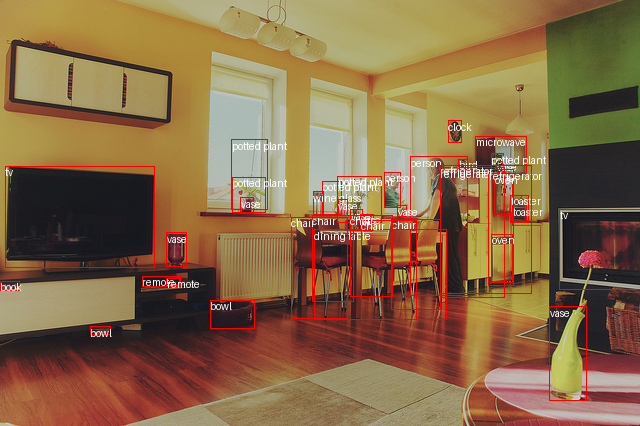

In [ ]:
from PIL import ImageDraw

visualized_image = image.copy()

draw = ImageDraw.Draw(visualized_image)

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = tuple(box)
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=text[label])

for box, label in zip(pipeline_boxes, pipeline_labels):
    draw.rectangle(xy=((box['xmin'], box['ymin']), (box['xmax'], box['ymax'])), outline='blue')
    draw.text(xy=(box['xmin'], box['ymin']), text=label)



visualized_image
     